In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse

In [2]:
#Creating a list for company name
company_list = ['INFY' , 'TCS']
company_LC = ['infy' , 'tcs']

In [3]:
# Create a dictionary of DataFrames
df = {} 

for i,comp in enumerate(company_list):
    
    #storing the data from csv in the dictionary
    df[comp] = pd.read_csv(f"./archive/{company_LC[i]}_stock.csv",
                     usecols=['Date','Open', 'High', 'Low','Close', 'Volume'], parse_dates=['Date'],index_col='Date')

In [ ]:
# Display the first few values of one of the dataframe
# df['INFY'].head()
df['TCS'].head()

In [ ]:

df[company[1]].loc['2015-01-07',:]

In [ ]:
df[company_list[0]].info()
df["TCS"].head()

In [ ]:
company_name = company_list[0];
print("Min:",df[company_name].index.min())
print("Max:",df[company_name].index.max())

In [ ]:
company_list

In [ ]:
plt.figure(figsize=(15,3))
plt.subplots_adjust(top=1.25 , bottom = 1.2)

for i,company in enumerate(company_list,1):
    plt.subplot(1,2,i)
    df[company].Close.plot()
    plt.title(f"Closing Price {company}",fontsize=20)
plt.show()

In [ ]:
column_name = df[company_list[0]].columns[3:5]

In [ ]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(top=3 , bottom = 1.5)

column_name = df[company_list[0]].columns[3:5]
k = 1;
for i,company in enumerate(company_list, 1):
    
    for j,column in enumerate(column_name,1):
        plt.subplot(2,2,k)
        df[company][column].plot()
        k = k+1;
        plt.title(f"{column} ({company})",fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
df[company_list[0]].Close['2015-06-12']

In [ ]:
# Ajusting the split for INFY stock that happened on 15/06/2015
plt.figure(figsize=(17,5))
stock_price = {}
stock_price[company_list[0]] = pd.concat([df[company_list[0]].Close[:'2015-06-12']/2,df[company_list[0]].Close['2015-06-15':]]) # adjustment
plt.plot(stock_price[company_list[0]])
plt.title(f"Closing Price Adjusted {company_list[0]}",fontsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(17,5))
stock_price[company_list[1]] = pd.concat([df[company_list[1]].Close[:'2015-06-12'],df[company_list[1]].Close['2015-06-15':]]) # adjustment
plt.plot(stock_price[company_list[1]])
plt.title(f"Closing Price Adjusted {company_list[1]}",fontsize=20)
plt.show()

In [ ]:
# And now we have an adjusted time series of Infosys stock prices.
# Lets now Predict the Stock price based on various methods.
#helper function to plot the stock prediction
# prev_values = stock_price[company_list[0]].iloc[:180] #train
# y_test = stock_price[company_list[0]].iloc[180:] #test

def plot_pred(pred,title):
    plt.figure(figsize=(17,5))
    plt.plot(prev_values,label='Train')
    plt.plot(y_test,label='Actual')
    plt.plot(pred,label='Predicted')
    plt.ylabel("Stock prices")
    plt.title(title,fontsize=20)
    plt.legend()
    plt.show()

In [ ]:
#helper function to plot the stock prediction


def plot_pred_list(pred,title,comp):
    prev_values = stock_price[comp].iloc[:180] #train
    y_test = stock_price[comp].iloc[180:] #test
    plt.figure(figsize=(17,5))
    plt.plot(prev_values,label='Train')
    plt.plot(y_test,label='Actual')
    plt.plot(pred,label='Predicted')
    plt.ylabel("Stock prices")
    plt.title(title,fontsize=20)
    plt.legend()
    plt.show()

In [ ]:
#Average of previous values

def calc_mse(comp):
    prev_values = stock_price[comp].iloc[:180] #train
    y_test = stock_price[comp].iloc[180:] #test
    y_av = pd.Series(np.repeat(prev_values.mean(),y_test.size),index=y_test.index)
    mse_calc = mse(y_av,y_test)
    return y_av,mse_calc;

In [ ]:
ccal,mse_comp = calc_mse('INFY')
mse_comp

In [ ]:
# # prev_values = stock_price['INFY'].iloc[:180] #train
# # y_test = stock_price['INFY'].iloc[180:] #test
# # y_av = pd.Series(np.repeat(prev_values.mean(),y_test.size),index=y_test.index)
# # y_test
# # prev_values
# # y_av
# # mse_calc = mse(y_av,y_test)
# # mse_calc
# y_av = calc_mse('INFY')
# y_av1 = calc_mse('TCS')
# print(y_av)
# print(y_av1)
# prev_values = stock_price['TCS'].iloc[:180] #train
# print(prev_values)


In [ ]:
np.sqrt(mse_comp)

In [ ]:
for i,comp in enumerate(company_list):
    y_av_comp,mse_comp = calc_mse(comp)
    plot_pred_list(y_av_comp,"Average",comp)
    print(mse_comp)

In [ ]:
# Weighted mean

def wa_mean(comp):
    prev_values = stock_price[comp].iloc[:180] #train
    y_test = stock_price[comp].iloc[180:] #test
    weight = np.array(range(0,180))/180
    weighted_train_data =np.multiply(prev_values,weight)

    # weighted average is the sum of this weighted train data by the sum of the weight

    weighted_average = sum(weighted_train_data)/sum(weight)
    y_wa = pd.Series(np.repeat(weighted_average,y_test.size),index=y_test.index)
    print("MSE: " ,mse(y_wa,y_test))
    print("RMSE: " ,np.sqrt(mse(y_wa,y_test)))
    return y_wa;

In [ ]:
for i,comp in enumerate(company_list):
    y_wa = wa_mean(comp)
    plot_pred_list(y_wa,"Weighted Average",comp)

In [ ]:
#      For the other methods we will predict the value of stock price on a day based on the values of stock prices of 80 days prior to it. So in our series we will not consider the first eight days (since there previous eighty days is not in the series).
#     We have to test the last 68 values. This would be based on the last 80 days stock prices of each day in the test data.
#     Since we have neglected first 80 and last 68 is our test set, the train dataset will be between 80 and 180 (100 days).
    y_train = stock_price[company_list[0]][80:180]
    y_test = stock_price[company_list[0]][180:]
    print("y train:",y_train.shape,"\ny test:",y_test.shape)

In [ ]:
stock_price[comp].size-y_test.size

In [ ]:

def train_test(comp):
    y_train = stock_price[comp][80:180]
    y_test = stock_price[comp][180:]
    X_train = pd.DataFrame([list(stock_price[comp][i:i+80]) for i in range(100)],
                           columns=range(80,0,-1),index=y_train.index)
    X_test = pd.DataFrame([list(stock_price[comp][i:i+80]) for i in range(100,stock_price[comp].size-80)],
                           columns=range(80,0,-1),index=y_test.index)
    return X_train,X_test,y_train,y_test;


In [ ]:

X_train,X_test,y_train,y_test = train_test('INFY')

In [ ]:
y_ma = X_test.mean(axis=1)
mse(y_ma,y_test), np.sqrt(mse(y_ma,y_test))

In [ ]:
plot_pred_list(y_ma,"Moving Average",'INFY')

In [ ]:
weight = np.array(range(1,81))/80
#weighted moving average
y_wma = X_test@weight/sum(weight)
mse(y_wma,y_test),np.sqrt(mse(y_wma,y_test))

In [ ]:
plot_pred_list(y_wma,"Weighted Moving Average",'INFY')

In [ ]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()

m_lr = {}

for i,comp in enumerate(company_list):
    X_train,X_test,y_train,y_test = train_test(comp)
    m_lr[comp] = lr.fit(X_train,y_train) # Training the models
    y_lr = m_lr[comp].predict(X_test) # inference
    y_lr = pd.Series(y_lr,index=y_test.index)
    print(f"MSE for {comp} = {mse(y_test,y_lr)} and RMSE {np.sqrt(mse(y_test,y_lr))}")
    plot_pred_list(y_lr,"Linear Regression",comp)

In [ ]:
# for i,comp in enumerate(company_list):
#     plot_pred_list(y_lr,"Linear Regression",comp)

In [ ]:
weight = np.array(range(1,101))/100
wlr = LinearRegression()

m_wlr = {}

for i,comp in enumerate(company_list):
    X_train,X_test,y_train,y_test = train_test(comp)
    m_wlr[comp] = wlr.fit(X_train,y_train,weight) # Training the models
    y_wlr = m_wlr[comp].predict(X_test) # inference
    y_wlr = pd.Series(y_wlr,index=y_test.index)
    print(f"MSE for {comp} = {mse(y_test,y_wlr)} and RMSE {np.sqrt(mse(y_test,y_wlr))}")
    plot_pred_list(y_wlr,"Weighted Linear Regression",comp)

In [ ]:
# weight = np.array(range(1,101))/100
# wlr = LinearRegression()

# wlr.fit(X_train,y_train,weight)
# y_wlr = wlr.predict(X_test)
# y_wlr = pd.Series(y_wlr,index=y_test.index)

# mse(y_test,y_wlr), np.sqrt(mse(y_test,y_wlr))

In [ ]:
# plot_pred(y_wlr,"Weighted Linear Regression")

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso()

las = lasso.fit(X_train,y_train)
y_las = las.predict(X_test)
y_las = pd.Series(y_las,index = y_test.index)

mse(y_las,y_test), np.sqrt(mse(y_test,y_wlr))

In [ ]:
from sklearn.linear_model import Lasso
lasso=Lasso()

m_lasso = {}

for i,comp in enumerate(company_list):
    X_train,X_test,y_train,y_test = train_test(comp)
    m_lasso[comp] = lasso.fit(X_train,y_train) # Training the models
    y_las = m_lasso[comp].predict(X_test) # inference
    y_las = pd.Series(y_las,index=y_test.index)
    print(f"MSE for {comp} = {mse(y_las,y_test)} and RMSE {np.sqrt(mse(y_las,y_test))}")
    plot_pred_list(y_las,"Linear Regression",comp)

In [ ]:
# plot_pred(y_las,"Lasso Regression")

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

ma_nn,history = {},{}

#moving average Neural Network
for i,comp in enumerate(company_list):
    
    X_train,X_test,y_train,y_test = train_test(comp)
    
    ma_nn[comp] = Sequential([Dense(64,input_shape=(80,),activation='relu'), 
                        Dense(32,activation='linear'),Dense(1)])
    
    ma_nn[comp].compile(loss='mse',optimizer='rmsprop',metrics=['mae','mse'])
    
    history[comp] = ma_nn[comp].fit(X_train, y_train, epochs=250, batch_size=32, validation_split=0.25)
    
    # Plotting the graph of mse vs no. of epochs
    plt.plot(history[comp].history['mse'],label='Training loss')
    plt.plot(history[comp].history['val_mse'], label='Validation loss')
    plt.title(f"Mean Squared error {comp}")
    plt.xlabel("Number of Epochs")
    plt.legend()
    plt.show()

In [ ]:
# plt.plot(history.history['mse'],label='Training loss')
# plt.plot(history.history['val_mse'], label='Validation loss')
# plt.title("Mean Squared error")
# plt.xlabel("Number of Epochs")
# plt.legend()
# plt.show()

In [ ]:
for i,comp in enumerate(company_list):
    X_train,X_test,y_train,y_test = train_test(comp)
    loss_nn,mae_nn,mse_nn = ma_nn[comp].evaluate(X_test,y_test)
    print(f"\nloss for {comp}:",loss_nn,f"\nmae for {comp}:",mae_nn,"\nmse for {comp}:",mse_nn)

In [ ]:
# loss_nn,mae_nn,mse_nn = ma_nn.evaluate(X_test,y_test)
# print("\nloss:",loss_nn,"\nmae:",mae_nn,"\nmse:",mse_nn)

In [ ]:
df['TCS'].head()

In [ ]:
y_nn = {}

for i,comp in enumerate(company_list):
    X_train,X_test,y_train,y_test = train_test(comp)
    y_nn[comp] = ma_nn[comp].predict(X_test)
    y_nn[comp] = pd.Series(y_nn[comp][:,0],index=y_test.index)
    print(f"{mse(y_nn[comp],y_test)},{np.sqrt(mse(y_nn[comp],y_test))}")

In [ ]:
# # y_nn = ma_nn.predict(X_test)
# # y_nn = pd.Series(y_nn[:,0],index=y_test.index)
# # mse(y_nn,y_test),np.sqrt(mse(y_nn,y_test))
# X_train,X_test,y_train,y_test = train_test('INFY')
# y_nn['INFY'] = ma_nn[comp].predict(X_test)
# y_nn['INFY'] = pd.Series(y_nn['INFY'][:,0],index=y_test.index)
# mse(y_nn['INFY'],y_test),np.sqrt(mse(y_nn['INFY'],y_test))

In [ ]:
for i,comp in enumerate(company_list):
    plot_pred_list(y_nn[comp],"Moving Average Prediction",comp)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [178]:
df = {}

company_list = ['comp']

for i,comp in enumerate(company_list):

    df[comp]=pd.read_csv(f"./archive/{comp}_stock.csv")
    df[comp].head()
    df[comp] = df[comp].dropna()
    df[comp] = df[comp].round(2)

    
daf = df['comp'].isnull().sum()
daf
# 
# df['TCS'] = df['TCS'].dropna()
# df['TCS'].head()
# daf = df['TCS'].isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [144]:
df['comp'].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,5200.90,5238.45,5167.10,5232.20,5232.20,0.0
1,2010-01-05,5277.15,5288.35,5242.40,5277.90,5277.90,0.0
2,2010-01-06,5278.15,5310.85,5260.05,5281.80,5281.80,0.0
3,2010-01-07,5281.80,5302.55,5244.75,5263.10,5263.10,0.0
4,2010-01-08,5264.25,5276.75,5234.70,5244.75,5244.75,0.0


In [166]:
from sklearn.preprocessing import MinMaxScaler

def create_dataset(comp):
    
    df[comp]["Date"]=pd.to_datetime(df[comp].Date,format="%Y-%m-%d")
    df[comp].index=df[comp]['Date']
    
    data=df[comp].sort_index(ascending=True,axis=0)
    new_dataset=pd.DataFrame(index=range(0,len(df[comp])),columns=['Date','Close'])
    for i in range(0,len(data)):
        new_dataset["Date"][i]=data['Date'][i]
        new_dataset["Close"][i]=data["Close"][i]


    new_dataset.index=new_dataset.Date
    new_dataset.drop("Date",axis=1,inplace=True)
    final_dataset=new_dataset.values
#     train_len = np.ceil(final_dataset.size*0.95)
#     train_len = np.floor(final_dataset.values.size)
    train_data=final_dataset[0:187,:]
    valid_data=final_dataset[187:,:]
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_data=scaler.fit_transform(final_dataset)
    
    dataset = { 0 : new_dataset, 1 : train_data, 2 : valid_data, 3 : scaled_data}
    return dataset;

In [170]:
from sklearn.preprocessing import MinMaxScaler

def create_dataset(comp):
    
    df[comp]["Date"]=pd.to_datetime(df[comp].Date,format="%Y-%m-%d")
    df[comp].index=df[comp]['Date']
    
    data=df[comp].sort_index(ascending=True,axis=0)
    new_dataset=pd.DataFrame(index=range(0,len(df[comp])),columns=['Date','Close'])
    for i in range(0,len(data)):
        new_dataset["Date"][i]=data['Date'][i]
        new_dataset["Close"][i]=data["Close"][i]


    new_dataset.index=new_dataset.Date
    new_dataset.drop("Date",axis=1,inplace=True)
    final_dataset=new_dataset.values
    train_len = int(np.ceil(final_dataset.size*0.95))
#     train_len = np.floor(final_dataset.values.size)
    train_data=final_dataset[0:train_len,:]
    valid_data=final_dataset[train_len:,:]
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_data=scaler.fit_transform(final_dataset)
    
    dataset = { 0 : new_dataset, 1 : train_data, 2 : valid_data, 3 : scaled_data}
    return dataset;

In [182]:
dataset = create_dataset('comp')
train_data = dataset[1]
new_dataset = dataset[0]
# final_dataset=new_dataset.values
# train_len = np.ceil(final_dataset.size*0.95)
# train_len
new_dataset.values.size
len(new_dataset.values)-len(train_data)

133

In [168]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.optimizers import Adam

# lstm_model = {}

def lstm_train(comp,dataset):

    new_dataset = dataset[0]
    train_data = dataset[1]
    valid_data = dataset[2]
    scaled_data = dataset[3]
    
    x_train_data,y_train_data=[],[]
    for i in range(60,len(train_data)):
        x_train_data.append(scaled_data[i-60:i,0])
        y_train_data.append(scaled_data[i,0])

    x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

    x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

    lstm_model =Sequential()
    lstm_model.add(LSTM(128, return_sequences=True, input_shape= (x_train_data.shape[1], 1)))
    lstm_model.add(LSTM(64, return_sequences=False))
    lstm_model.add(Dense(25))
    lstm_model.add(Dense(1))

    learning_rate = 0.0001  # Set your desired learning rate value
    optimizer = Adam(learning_rate=learning_rate)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
#     lstm_model.compile(loss='mean_squared_error',optimizer='adam')
    lstm_model.fit(x_train_data,y_train_data,epochs=10,batch_size=1,verbose=2)
    
    return lstm_model;

In [189]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.optimizers import Adam

# lstm_model = {}

def lstm_train(comp,dataset):

    new_dataset = dataset[0]
    train_data = dataset[1]
    valid_data = dataset[2]
    scaled_data = dataset[3]
    
    test_len = len(new_dataset.values) - len(train_data)
    x_train_data,y_train_data=[],[]
    for i in range(test_len,len(train_data)):
        x_train_data.append(scaled_data[i-test_len:i,0])
        y_train_data.append(scaled_data[i,0])

    x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

    x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

    lstm_model =Sequential()
    lstm_model.add(LSTM(128, return_sequences=True, input_shape= (x_train_data.shape[1], 1)))
    lstm_model.add(LSTM(64, return_sequences=False))
    lstm_model.add(Dense(25))
    lstm_model.add(Dense(1))

    learning_rate = 0.0001  # Set your desired learning rate value
    optimizer = Adam(learning_rate=learning_rate)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
#     lstm_model.compile(loss='mean_squared_error',optimizer='adam')
    lstm_model.fit(x_train_data,y_train_data,epochs=2,batch_size=1,verbose=2)
    
    return lstm_model;

In [185]:
def create_xtest(dataset):
    
    new_dataset = dataset[0]
    train_data = dataset[1]
    valid_data = dataset[2]
    scaled_data = dataset[3]
    test_len = len(new_dataset.values) - len(train_data)
    final_dataset=new_dataset.values
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_data=scaler.fit_transform(final_dataset)
    
    inputs_data=new_dataset[len(new_dataset)-len(valid_data)-test_len:].values
    inputs_data=inputs_data.reshape(-1,1)
    inputs_data=scaler.transform(inputs_data)

    X_test=[]
    for i in range(test_len,inputs_data.shape[0]):
        X_test.append(inputs_data[i-test_len:i,0])
    X_test=np.array(X_test)

    X_test
    
    return X_test;

In [186]:
def predict_stock_list(lstm_model,X_test,dataset):
#     new_dataset,train_data,valid_data,scaled_data = create_dataset(comp)
    new_dataset = dataset[0]
    train_data = dataset[1]
    valid_data = dataset[2]
    scaled_data = dataset[3]

    final_dataset=new_dataset.values
    scaler=MinMaxScaler(feature_range=(0,1))
    scaled_data=scaler.fit_transform(final_dataset)
    
    
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
#     lstm_model = lstm_train(comp,dataset)
    closing_price=lstm_model.predict(X_test)
    closing_price=scaler.inverse_transform(closing_price)
#     lstm_model.save(f"saved_lstm_model.h5")
    return closing_price;

In [130]:
# closing_price = {}

# for i,comp in enumerate(company_list):
#     dataset = create_dataset(comp)
#     lstm_model = lstm_train(comp,dataset)
#     X_test = create_xtest(dataset)
#     closing_price[comp] =  predict_stock_list(lstm_model,X_test,dataset)
#     new_dataset = dataset[0]
#     train_data=new_dataset[:187]
#     valid_data=new_dataset[187:]
#     valid_data['Predictions']=closing_price
#     plt.plot(train_data["Close"],color='blue')
#     plt.plot(valid_data["Close"])
#     plt.plot(valid_data["Predictions"], color='red')

Epoch 1/10
127/127 - 8s - loss: 0.0393 - 8s/epoch - 62ms/step
Epoch 2/10
127/127 - 5s - loss: 0.0075 - 5s/epoch - 39ms/step
Epoch 3/10
127/127 - 4s - loss: 0.0066 - 4s/epoch - 33ms/step
Epoch 4/10
127/127 - 4s - loss: 0.0053 - 4s/epoch - 30ms/step
Epoch 5/10
127/127 - 4s - loss: 0.0050 - 4s/epoch - 35ms/step
Epoch 6/10
127/127 - 5s - loss: 0.0050 - 5s/epoch - 39ms/step
Epoch 7/10
127/127 - 5s - loss: 0.0047 - 5s/epoch - 37ms/step
Epoch 8/10
127/127 - 5s - loss: 0.0049 - 5s/epoch - 42ms/step
Epoch 9/10
127/127 - 5s - loss: 0.0044 - 5s/epoch - 41ms/step
Epoch 10/10
127/127 - 5s - loss: 0.0045 - 5s/epoch - 42ms/step
2/2 [==============================] - 1s 49ms/step


C:\Users\venka\AppData\Local\Temp/ipykernel_18104/1477203335.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


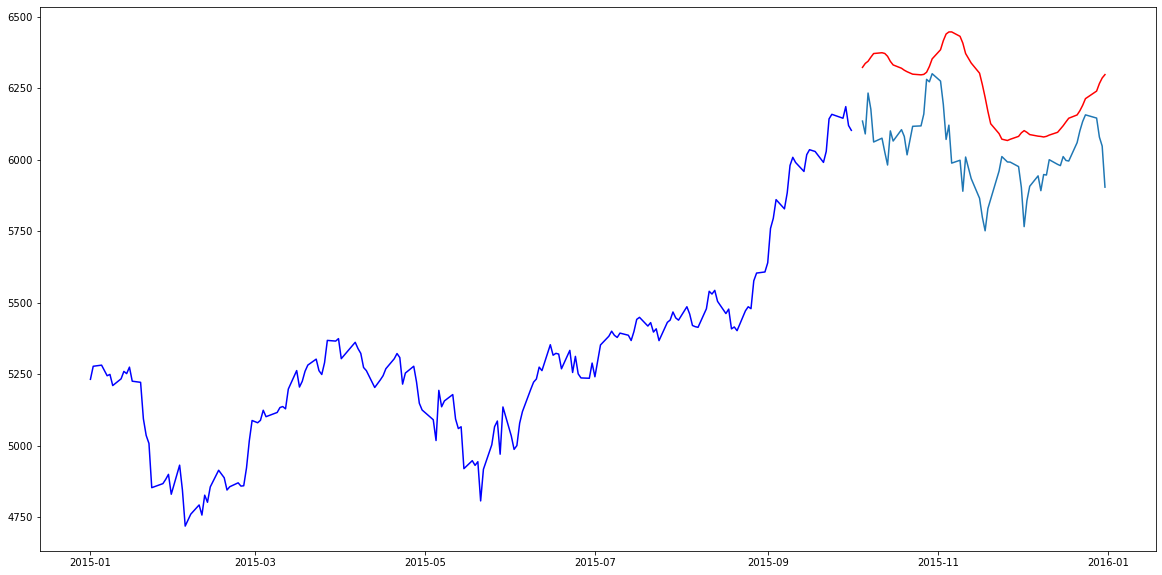

In [131]:
comp = 'TCS'

dataset = create_dataset(comp)
lstm_model = lstm_train(comp,dataset)
X_test = create_xtest(dataset)
closing_price = predict_stock_list(lstm_model,X_test,dataset)
new_dataset = dataset[0]
train_data=new_dataset[:187]
valid_data=new_dataset[187:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"],color='blue')
plt.plot(valid_data["Close"])
plt.plot(valid_data["Predictions"], color='red')

Epoch 1/2
2401/2401 - 191s - loss: 0.0025 - 191s/epoch - 80ms/step
Epoch 2/2
2401/2401 - 186s - loss: 5.1985e-04 - 186s/epoch - 77ms/step
5/5 [==============================] - 1s 139ms/step


C:\Users\venka\AppData\Local\Temp/ipykernel_18104/1478467821.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


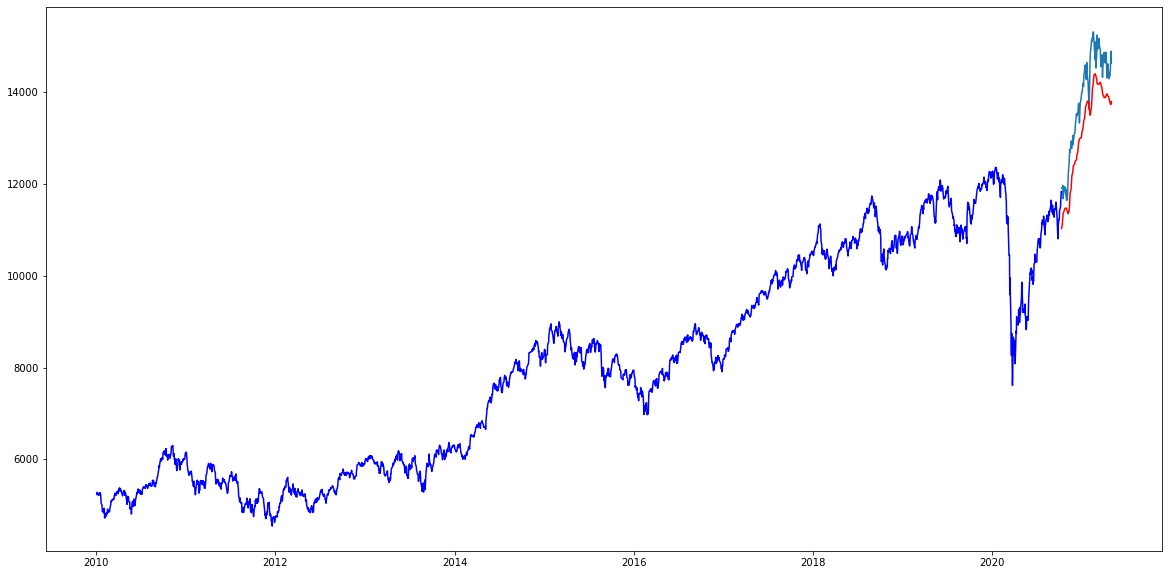

In [190]:
comp = 'comp'

dataset = create_dataset(comp)
lstm_model = lstm_train(comp,dataset)
X_test = create_xtest(dataset)
closing_price = predict_stock_list(lstm_model,X_test,dataset)
new_dataset = dataset[0]
train_len = int(np.ceil(new_dataset.values.size*0.95))
train_data=new_dataset[:train_len]
valid_data=new_dataset[train_len:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"],color='blue')
plt.plot(valid_data["Close"])
plt.plot(valid_data["Predictions"], color='red')

In [135]:
# Testing the model 

# comp = 'TCS'

# dataset = create_dataset(comp)
# lstm_model = lstm_train(comp,dataset)
# X_test = create_xtest(dataset)
# closing_price = predict_stock_list(lstm_model,X_test,dataset)
# new_dataset = dataset[0]
# train_data=new_dataset[:187]
# valid_data=new_dataset[187:]
# valid_data['Predictions']=closing_price
# plt.plot(train_data["Close"],color='blue')
# plt.plot(valid_data["Close"])
# plt.plot(valid_data["Predictions"], color='red')

In [191]:
# Calculating accuracy of predictions

abs_diff = np.abs(closing_price - valid_data["Close"].values)

# Calculate the percentage difference between absolute difference and actual values
percentage_diff = abs_diff / valid_data["Close"].values * 100

# Calculate the average percentage accuracy
accuracy = 100 - np.mean(percentage_diff)

# Print the accuracy
print(f"Percentage Accuracy: {accuracy}%")

# valid_data["Close"].values
# closing_price.size

Percentage Accuracy: 90.10311735721689%


In [133]:
# Calculating accuracy of predictions

abs_diff = np.abs(closing_price - valid_data["Close"].values)

# Calculate the percentage difference between absolute difference and actual values
percentage_diff = abs_diff / valid_data["Close"].values * 100

# Calculate the average percentage accuracy
accuracy = 100 - np.mean(percentage_diff)

# Print the accuracy
print(f"Percentage Accuracy: {accuracy}%")

# valid_data["Close"].values
# closing_price.size

Percentage Accuracy: 96.06848211032843%


In [134]:
closing_price

array([[6323.717 ],
       [6337.5835],
       [6345.152 ],
       [6359.35  ],
       [6372.1807],
       [6374.975 ],
       [6372.442 ],
       [6362.4756],
       [6344.8003],
       [6332.31  ],
       [6320.6987],
       [6313.7935],
       [6308.526 ],
       [6299.9565],
       [6297.621 ],
       [6299.205 ],
       [6306.6626],
       [6326.8843],
       [6353.511 ],
       [6385.4355],
       [6417.053 ],
       [6440.4463],
       [6447.6587],
       [6447.8477],
       [6432.37  ],
       [6408.6797],
       [6372.198 ],
       [6338.9897],
       [6303.428 ],
       [6263.6606],
       [6218.7227],
       [6169.59  ],
       [6126.4775],
       [6091.955 ],
       [6072.502 ],
       [6067.8657],
       [6072.123 ],
       [6082.3022],
       [6094.699 ],
       [6102.4067],
       [6096.3867],
       [6088.566 ],
       [6083.0933],
       [6082.0674],
       [6080.21  ],
       [6082.391 ],
       [6086.8037],
       [6096.5356],
       [6107.906 ],
       [6119.521 ],
